In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

import pickle

# add utilities directory to path
import os, sys
util_path = os.path.abspath('utilities_and_data')
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility
import stan_helper

import pystan

In [2]:
def get_stan_model(model_name, model_code, get_new=False):
    path = os.path.abspath(os.path.join(os.path.curdir, model_name))

    if not get_new and os.path.exists(path):
        print("Model exists already! Returning pickle.")
        return pickle.load(open(path, 'rb'))
    
    print("Path doesn't exist. Compiling model. It might take few minutes...")
    import pystan
    sm = pystan.StanModel(model_code=model_code)
    with open(model_name, 'wb') as f:
        pickle.dump(sm, f)
    return sm


In [5]:
with open("data/drowning.txt") as f:
    lines = f.read().splitlines()
    lines = [l.split() for l in lines]

years = np.array([int(l[0]) for l in lines])
victims = np.array([int(l[1]) for l in lines])
N = len(years)
xpred = 2016    # Predict for 2016

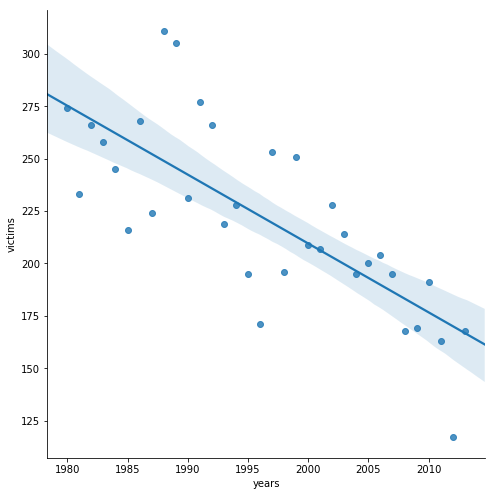

In [6]:
data =pd.DataFrame.from_items([('years',years), ('victims', victims)])
sns.pairplot(data, x_vars=['years'], y_vars='victims', size=7, kind='reg')

In [7]:
# Gaussian linear model with uniform priors
drowning_code = """
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
 }
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}
"""

In [8]:
data = dict(
    N = N,
    x = years,
    y = victims,
    xpred = xpred,
)

In [9]:
# sm = pystan.StanModel(model_code=drowning_code)
sm_drowning = get_stan_model('drowning_model.pkl', drowning_code)

Model exists already! Returning pickle.


## Question 1.1
What can you say about the trend in the number of people drown per year? Plot the histogram of the slope of the linear model.

In [10]:
fit = sm_drowning.sampling(data=data, iter=1000, chains=4); fit

Inference for Stan model: anon_model_3f0e86229606a6afeeb9deac4462804e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       6858.3   46.94 1051.6 4884.5 6145.9 6831.2 7506.3 8875.7    502   1.01
beta         -3.32    0.02   0.53  -4.34  -3.65  -3.31  -2.97  -2.34    502   1.01
sigma        29.49    0.16   3.89  23.39  26.77  29.01  31.52   39.2    596    1.0
mu[0]       275.74    0.41  10.05 255.83 269.22  275.6 282.45 295.28    609   1.01
mu[1]       272.41    0.38   9.59 253.71 266.21 272.28 278.85 291.24    623   1.01
mu[2]       269.09    0.36   9.15 251.16 263.24 268.96 275.28 287.12    639   1.01
mu[3]       265.76    0.34   8.72 248.78 260.16 265.73  271.6  282.9    659   1.01
mu[4]       262.44    0.32    8.3 246.33 257.16 262.44 267.98 278.87    682   1.01
mu[5]       259.11     0.3   7.88 243.82 254.06 259.19 264.42 274.

If you look at the inference for Stan model you can see that the number of people drown per year is decreasing in general.

In [11]:
samples = fit.extract(permuted=True)

### Histogram of the slope of the linear model

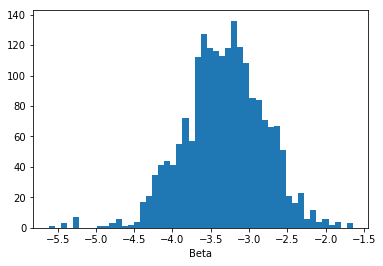

In [12]:
# Warmups are already discarded
plt.hist(samples['beta'], 50)
plt.xlabel("Beta")

### 2). What does the model predict for year 2016? Plot the histogram of the posterior predictive distribution for number of people drown at x = 2016.


For year 2016 the model predicts __156.95 people would die in average with standard error mean of 0.75__.


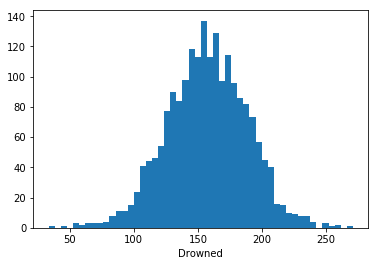

In [13]:
plt.hist(samples['ypred'], 50)
plt.xlabel("Drowned")

# 2. Hierarchical model: factory data with Stan (3p)

The provided factory.txt file contains quality control measurements from 6 machines in a factory (units of the measurements are irrelevant here). Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine. In addition to the existing machines, we are interested in the quality of another machine (the seventh machine). 

Implement a 
- separate, 
- pooled and 
- hierarchical Gaussian model 
    
described in Section 11.6 using Stan. 

Similarly as in the model description in the book, __use the same measurement standard deviation σ for all the groups in the hierarchical model__. In the separate model however, __use separate measurement standard deviation $\sigma_j$ for each group j__. 

Using each of the three models – separate, pooled, and hierarchical – report (__plot histogram and comment on the results__):

### Reference
- http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/#The-Models

## Questions
- What is the random variable here?
    - How do we predict without rv?
    - What is predictive distribution?

Load model

In [50]:
d = np.loadtxt("data/factory.txt")

## (2-1). Separate model with unequal standard deviations

$$ y_{i,m} = \alpha_m + \beta_m \times \text{machine}_{i,m} + \epsilon_m $$

- $i$: measurement index
- $m$: machine being measured

$\epsilon$ is an error term sampled from $N(\mu, \sigma_\epsilon)$

Here we say that all six machines are completely different with no similarities. Based on this model we won't be able to predict another machine.

In [60]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 6,  # 6 machines
    x = x,  # group indicators
    y = y,   # observations
    target_machine = 5  # 6th machine
)

x.shape, y.shape

((30,), (30,))

In [52]:
#  Comparison of k groups with common variance (ANOVA)
data_code = '''
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
  int<lower=0> target_machine;
}
parameters {
  vector[K] mu;        // group means
  vector<lower=0>[K] sigma; // group stds
  //real<lower=0> sigma; // common std
}
model {
  //for (i in 1:N)
  //  y[i] ~ normal(mu[x[i]], sigma[x[i]]);
    y ~ normal(mu[x], sigma[x]);
}

generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(mu[target_machine], sigma[target_machine]);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);
}
'''

In [53]:
# sm_separate = get_stan_model('factory_model.pkl', data_code, get_new=True)
sm_separate = get_stan_model('factory_model.pkl', data_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_90809f19c30be940fe67ea685b89ec73 NOW.


Path doesn't exist. Compiling model. It might take few minutes...


In [54]:
fit_separate = sm_separate.sampling(data=data, seed=194838);fit_separate

Inference for Stan model: anon_model_90809f19c30be940fe67ea685b89ec73.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        76.46    0.45  15.63  46.03  68.36  76.12  84.05 106.05   1228    1.0
mu[1]       106.36    0.38   10.5  87.58 101.42 106.04 110.82  125.6    754   1.01
mu[2]        87.67    0.24  10.07  66.71  82.69  87.56   92.8 108.19   1788    1.0
mu[3]       111.61    0.22   6.31  99.63 108.69 111.61 114.61 123.63    811    1.0
mu[4]        90.08    0.19   8.29  72.67  85.96  90.14  94.22 106.56   1912    1.0
mu[5]        85.63    0.56  17.72  53.34   78.3  85.52  92.74 118.63    989    1.0
sigma[0]     30.35    0.65  19.73  13.16  19.56  25.13  34.76  75.44    926    1.0
sigma[1]     18.79    0.45  12.69   7.73   11.6   15.4  21.37  52.34    796    1.0
sigma[2]     20.15    0.34  12.61    8.4  12.77  16.61  23.33  5

In [55]:
# Extract samples in different forms for different parameters.
# permuted : bool
#    If True, returned samples are permuted. All chains are
#    merged and warmup samples are discarded.
samples_separate = fit_separate.extract(permuted=True)

stan_utility.check_treedepth(fit_separate)
stan_utility.check_energy(fit_separate)
stan_utility.check_div(fit_separate)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


`mu` is group mean. So get a column not row.

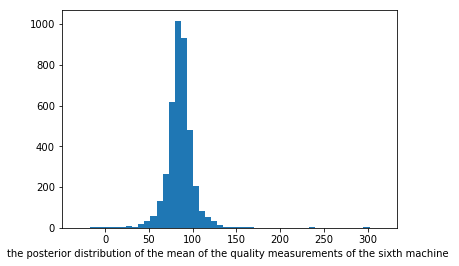

In [56]:
plt.hist(samples_separate['mu'][:,5], 50)
plt.xlabel("the posterior distribution of the mean of the quality measurements of the sixth machine ")

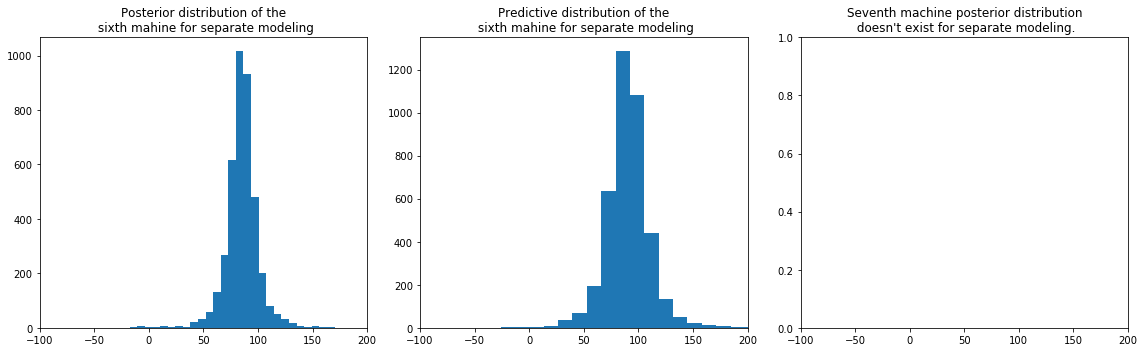

In [84]:
# create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

# plot the posterior density
ax = axes[0]
ax.set_xlim([-100,200])
ax.hist(samples_separate['mu'][:,5], 50)
ax.set_title('Posterior distribution of the\n sixth mahine for separate modeling')

ax = axes[1]
ax.hist(samples_separate['ypred'], 50)
ax.set_title("Predictive distribution of the\n sixth mahine for separate modeling")

ax = axes[2]
ax.set_title("Seventh machine posterior distribution\n doesn't exist for separate modeling.")


fig.tight_layout()

Posterior and predictive distributions look similar. For separate modeling, the seventh machine's posterior distribution doesn't exist, because separate modeling cannot infer a new machine as all six machines were supposed as completely different machies.

## (2-2). Pooled model

$$ y_{i,m} = \alpha + \beta \times \text{machine}_{i,m} + \epsilon_m $$

- $i$: measurement index
- $m$: machine being measured

$\epsilon$ is an error term sampled from $N(\mu, \sigma_\epsilon)$

So here we are aggregating all the machines into a single machines as they are __exactly__ the same.

In [29]:
# Gaussian linear model with uniform priors
pooling_code = """
data {
  int<lower=0> N; // number of data points
  vector[N] y; //
}
parameters {
  real mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(mu, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu, sigma);
}
"""

In [30]:
sm_pooled = get_stan_model("factory_pooling_posterior", pooling_code, get_new=True)
# sm = get_stan_model("factory_pooling_posterior", pooling_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e37fd519a1160a9347f6f67db924f61d NOW.


Path doesn't exist. Compiling model. It might take few minutes...


Pool all the observations. I don't know how to not to use vectors so treat this as observations of 1 machine

In [31]:
x = np.full(1, 1)
y = d.ravel();y
N = len(y)
data = dict(
    N = N,
    y = y   # observations
)

In [32]:
fit_pooled = sm_pooled.sampling(data=data, seed=194838);fit_pooled

Inference for Stan model: anon_model_e37fd519a1160a9347f6f67db924f61d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            92.9    0.07   3.54  86.01  90.54  92.91  95.23  99.98   2709    1.0
sigma         18.8    0.05   2.58  14.56  16.98  18.53  20.35  24.46   2684    1.0
ypred        93.36    0.31  19.33   55.9  80.32   93.3 105.94  131.5   4000    1.0
log_lik[0]   -4.01  2.7e-3   0.14   -4.3   -4.1   -4.0  -3.91  -3.75   2655    1.0
log_lik[1]   -4.73  4.9e-3   0.27  -5.34  -4.89   -4.7  -4.54  -4.29   2948    1.0
log_lik[2]   -3.96  2.8e-3   0.14  -4.26  -4.05  -3.95  -3.86  -3.71   2476    1.0
log_lik[3]   -4.08  2.9e-3   0.15  -4.39  -4.18  -4.07  -3.97  -3.82   2570    1.0
log_lik[4]   -4.15  3.0e-3   0.16  -4.48  -4.25  -4.14  -4.04  -3.86   2757    1.0
log_lik[5]   -5.79  9.8e-3   0.53  -6.93   -6.1  -5.73   -5.4  -

In [34]:
samples_pooled = fit_pooled.extract(permuted=True)

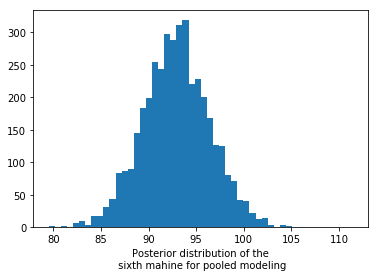

In [48]:
plt.hist(samples_pooled['mu'], 50)
plt.xlabel("Posterior distribution of the\n sixth mahine for pooled modeling")

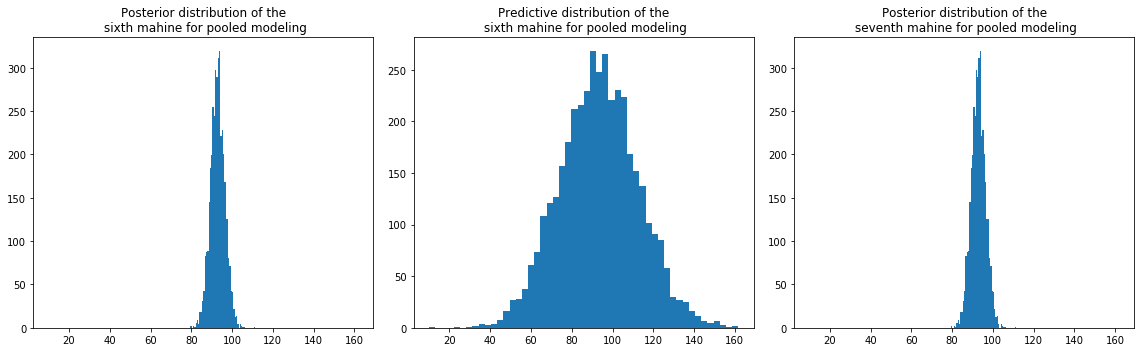

In [87]:
# create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

# plot the posterior density
ax = axes[0]
ax.hist(samples_pooled['mu'], 50)
ax.set_title('Posterior distribution of the\n sixth mahine for pooled modeling')

ax = axes[1]
ax.hist(samples_pooled['ypred'], 50)
ax.set_title("Predictive distribution of the\n sixth mahine for pooled modeling")

ax = axes[2]
ax.hist(samples_pooled['mu'], 50)
ax.set_title("Posterior distribution of the\n seventh mahine for pooled modeling")


fig.tight_layout()

The posterior distribution of the seventh mahine for pooled modeling is the same as any machine because they are __identical__ machines.

### (2-3) hierarchical model

Hierarchical modeling is a statistically rigorous way to make scientific inferences about a population based on many groups/observations. Humanly speaking, it's a middle ground between pooling and separate modeling. We will have the same formula as separate:

$$ y_{i,m} = \alpha_m + \beta_m \times \text{machine}_{i,m} + \epsilon_m $$

But $\alpha$ and $\beta$ come from a common group distribution:

$$\alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$

So we model coefficients and predictions. That's why it's called hierarchical/multilevel modeling.

In [76]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 7,  # 6 machines
    x = x,  # group indicators
    y = y,   # observations
    target_machine = 5  # 6th machine
)

Our linear model:
$$ y = \beta_0 + \beta_1 \times x + e $$

$e$ is an error term sampled from $N(\mu, \sigma)$

Priors for each machine is not fixed, but rather depend on other latent variables.

In [80]:
#  Comparison of k groups with common variance and
#  hierarchical prior for the mean

data_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
    int<lower=0> target_machine;
}
parameters {
    real<lower=70, upper=110> mu0; // uniform prior mean
    real<lower=0, upper=20> sigma0; // uniform prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
    real mu7;
}
model {
  //mu0 ~ normal(10,10);      // weakly informative prior
  //sigma0 ~ cauchy(0,4);     // weakly informative prior
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  //sigma ~ cauchy(0,4);      // weakly informative prior
  y ~ normal(mu[x], sigma);
  //for (i in 1:N)
  mu7 ~ normal(mu, sigma);  // Is this correct? Idk. mu7 ~ normal(mu0, sigma0) gave me low mean around 19.
}
generated quantities {
  real ypred;
  
  vector[N] log_lik;
  ypred = normal_rng(mu[target_machine], sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);
}
'''

In [81]:
sm_hierarchical =  pystan.StanModel(model_code=data_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6cc47a9f4a59f2b3cc1fb7670696e97 NOW.


In [75]:
fit_hierarchical = sm_hierarchical.sampling(data=data, seed=194838);fit_hierarchical

Inference for Stan model: anon_model_f6cc47a9f4a59f2b3cc1fb7670696e97.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0           93.0    0.11   5.31  82.07  89.65   93.0  96.36 103.61   2324    1.0
sigma0       10.95    0.13   4.22    3.0   7.87   10.6  14.04  19.08   1023    1.0
mu[0]         82.9    0.13   6.02   71.3  78.72   82.9   86.9   94.6   2012    1.0
mu[1]       100.76    0.12   5.69  89.35  97.08 100.84  104.6 111.86   2090    1.0
mu[2]        89.87    0.11   5.34  79.43  86.24  89.83  93.55 100.26   2340    1.0
mu[3]       103.88    0.14   6.14  91.82  99.76 104.09 108.05 115.61   1916    1.0
mu[4]        91.26    0.09   5.33  80.76  87.74   91.5  94.67 101.89   3254    1.0
mu[5]        88.89    0.11   5.36  78.06   85.5  88.93  92.46  99.34   2580    1.0
sigma        14.75    0.05   2.09  11.39  13.28  14.51  15.94  1

In [70]:
# Extract samples in different forms for different parameters.
# permuted : bool
#    If True, returned samples are permuted. All chains are
#    merged and warmup samples are discarded.
samples = fit_hierarchical.extract(permuted=True)

stan_utility.check_treedepth(fit_hierarchical)
stan_utility.check_energy(fit_hierarchical)
stan_utility.check_div(fit_hierarchical)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
36.0 of 4000 iterations ended with a divergence (0.9%)
Try running with larger adapt_delta to remove the divergences


`mu` is group mean. So get a column not row.

In [71]:
samples['mu'][:,5].shape,samples['ypred'].shape,samples['mu7'].shape

((4000,), (4000,), (4000,))

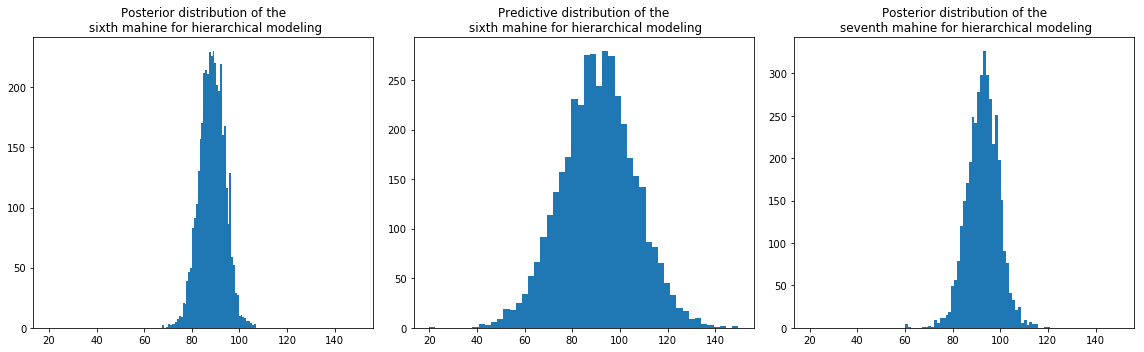

In [85]:
# create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

# plot the posterior density
ax = axes[0]
ax.hist(samples['mu'][:,5], 50)
ax.set_title('Posterior distribution of the\n sixth mahine for hierarchical modeling')

ax = axes[1]
ax.hist(samples['ypred'], 50)
ax.set_title("Predictive distribution of the\n sixth mahine for hierarchical modeling")

ax = axes[2]
ax.hist(samples['mu7'], 50)
ax.set_title("Posterior distribution of the\n seventh mahine for hierarchical modeling")


fig.tight_layout()

In [ ]:
The tdistributions 